# Desafío 1: Determinantes del ingreso
## __Hito 1, Preliminares__

### Enunciado:

Un organismo no gubernamental  está interesado en las dinámicas socioeconómicas que determinan la desigualdad de ingreso y la erradicación de la pobreza extrema, enmarcado dentro de los objetivos del desarrollo del nuevo milenio del Programa de las Naciones Unidas para el Desarrollo.

### Objetivo:

Desarrollar un modelo predictivo de clasificación sobre la probabilidad que un individuo presente salarios bajo los 50.000 dólares anuales, en base a una serie de atributos sociodemográficos $X_i$.

El modelo a estimar es:

$$\log\left(\frac{p({ income \gt 50000})}{1 - p({ income \gt 50000})}\right)={{\beta }_{0} + \sum_{i=1} {\beta }_{i} \cdot {X_{i}}}$$


### Implementación de la solución: 

- Se implementará una regresion logística para la clasificación de los salarios sobre y bajo los 50.000 dolares anuales, binarizando la variable `income` entre 0 y 1.
- El método de optimización es el de la máxima verosimilitud de la función de distribución binomial para la estimación de  parámetros.

### Métricas de evaluación

Se utilizarán las siguientes métricas:

- Matriz de confusión: cantidad de observaciones predichas de forma correcta.
- Accuracy (exactitud): porcentaje de casos predichos correctamente por sobre el total de casos.
- Precision: mide la fracción de predicciones correctas entre las etiquetas positivas.
- Recall: Mide la fraccion de verdaderos positivos predichos por el modelo.
- F1: representa la media armónica entre Precision y Recall (es decir, una medida general de la presición).
- ROC (en particular, AUC): evalúa la relación entre ambos errores (falsos positivos y falso negativo) condicional en todo el rango del clasificador.

Teniendo en consideración que el objetivo es erradización de la pobreza extrema y las dinámicas que determinan la desigualdad de ingresos.

### Estrategia de preprocesamiento de datos:

- Se realizará el siguiente preprocesamiento:
    - Transformación de datos pérdidos, los datos pérdidos simbolizados con `?` que se cambiarán a `NaN`.
    - Recodificación, se seguirá la sugerencia de la organización. Se detalla en sección recodifición.
    - Binarización: se recodificarán las variables binarias, con valor 1 a las categorías minoritarias.

## __Aspectos computacionales__

Se utilizara las principales librerias para el analisis de datos, las cuales son:

### Bibliotecas de Python 
 
- `pandas`:  Permite realizar tareas de manipulación, agregación y visualización de datos de forma más sencilla.
- `numpy`: Agrega soporte para vectores y matrices y  funciones matemáticas de alto nivel para operar con esos datos. 
- `matplotlib`: Permite crear visualizaciones de datos simples.
- `seaborn`: Permite visualizar modelos estadísticos. Se basa en Matplotlib.
- `statsmodels`: Estimación de modelos estadísticos, en nuestro caso la regresion logística.
- `scikit-learn`: Implementa aprendizaje de máquina, incluye varios algoritmos de clasificación, regresión y métricas, incluyendo varias herramientas útiles, como separación de datos de entrenamiento, validación cruzada y codificación de variables categóricas.
- `factor_analizer`: Permite implementar el EFA (análisis factorial exploratorio).
- `missingno`: Biblioteca para la visualización de datos perdidos.
- `warnings`: Evitará que aparezcan las advertencias de avisos de deprecación.


In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

import factor_analyzer as factor
import missingno as msngo
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('income-db.csv')
plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos

## __Hito 2, Descripción__

## Visualización de Conjunto de datos



In [2]:
# Vemos las columnas
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

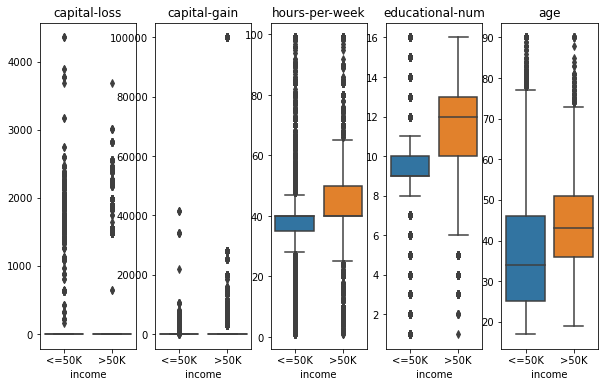

In [3]:
# Analizamos las variables continuas
fig, axes = plt.subplots(1,5)
plt.rcParams["figure.figsize"] = (16, 4) # Tamaño gráficos
sns.boxplot(x='income', y='capital-loss', data=df, ax=axes[0])
sns.boxplot(x='income', y='capital-gain', data=df, ax=axes[1])
sns.boxplot(x='income', y='hours-per-week', data=df, ax=axes[2])
sns.boxplot(x='income', y='educational-num', data=df, ax=axes[3])
sns.boxplot(x='income', y='age', data=df, ax=axes[4])
# Ajustar estilos de gráficos
for i in range(5):
    label = axes[i].get_ylabel()
    axes[i].set_ylabel(None)
    axes[i].set_title(label)
    box = axes[i].get_position()
    box.x0 = box.x0 + 0.099
    box.x1 = box.x1 + 0.099
    axes[i].set_position(box)

Tras analizar las columnas con valores continuos notamos que:
<ul>
    <li>Para las variaciones de capital (<code>capital-gain</code> y <code>capital-loss</code>) se tienen los primeros tres cuartiles con valores 0. De todos modos, se puede observar en la dispersión de los valores extremos que las personas que ganan mas de 50k, presentan ganancias mayores que los que no, y del mismo modo, los que ganan menos de 50k, presentan mayores pérdidas que los que no</li>
    <li>Las personas con mayor educación son frecuentemente las que tienen mas de 50k en ingresos.</li>
    <li>Tanto la edad como las horas de trabajo presentan una leve proporcionalidad a si gana mas de 50k</li>
</ul>

Para analizar las variables discretas primero haremos la recodificación pedida.

In [4]:

def refactorColumn(dataframe, baseCol, newCol, conversionDict):
    dataframe[newCol] = dataframe[baseCol].map(conversionDict)
    print(dataframe[newCol].value_counts())
# Se Refactoriza occupation
refactorColumn(df, 'occupation', 'collars', { 'Prof-specialty': 'white-collar', 'Exec-managerial': 'white-collar', 'Adm-clerical': 'white-collar',
'Sales': 'white-collar', 'Tech-support': 'white-collar','Craft-repair': 'blue-collar', 'Machine-op-inspct': 'blue-collar', 'Transport-moving': 'blue-collar',
'Handlers-cleaners': 'blue-collar', 'Farming-fishing': 'blue-collar', 'Protective-serv': 'blue-collar', 'Priv-house-serv': 'blue-collar','Other-service': 'others', 'Armed-Forces': 'others'})
# Se refactoriza workclass
refactorColumn(df, 'workclass', 'workclass_recod', {'Federal-gov': 'federal-gov', 'State-gov': 'state-level-gov', 'Local-gov': 'state-level-gov','Self-emp-inc': 'self-employed', 'Self-emp-not-inc': 'self-employed','Never-worked': 'unemployed', 'Without-pay': 'unemployed', 'Private': 'private'})
# Se refactoriza education
refactorColumn(df, 'education', 'educ_recod', {'Preschool': 'preschool','1st-4th': 'elementary-school', '5th-6th': 'elementary-school','7th-8th': 'high-school', '9th': 'high-school', '10th': 'high-school','11th': 'high-school', '12th': 'high-school', 'HS-grad': 'high-school','Assoc-voc': 'college', 'Assoc-acdm': 'college', 'Some-college': 'college', 'Bachelors': 'university', 'Masters': 'university', 'Prof-school': 'university', 'Doctorate': 'university'})
# Se refactoriza marital-status
refactorColumn(df, 'marital-status', 'civstatus', {'Married-civ-spouse': 'married', 'Married-spouse-absent': 'married',
'Married-AF-spouse': 'married', 'Divorced': 'divorced', 'Separated': 'separated', 'Widowed': 'widowed'})
# Se refactoriza native-country
refactorColumn(df, 'native-country', 'region', {'United-States': 'America', 'Cambodia': 'Africa', 'England': 'Europe', 'Puerto-Rico': 'America',
'Canada': 'America', 'Germany': 'Europe', 'Outlying-US(Guam-USVI-etc)': 'Oceania', 'India': 'Asia', 'Japan': 'Asia', 'Greece': 'Europe', 'South': 'Africa', 'China': 'Asia',
'Cuba': 'America', 'Iran': 'Asia', 'Honduras': 'America', 'Philippines': 'Asia', 'Italy': 'Europe', 'Poland': 'Europe', 'Jamaica': 'America', 'Vietnam': 'Asia', 'Mexico': 'America', 'Portugal': 'Europe',
'Ireland': 'Europe', 'France': 'Europe', 'Dominican-Republic': 'America', 'Laos': 'Asia', 'Ecuador': 'America', 'Taiwan': 'Asia', 'Haiti': 'America', 'Columbia': 'America',
'Hungary': 'Europe', 'Guatemala': 'America', 'Nicaragua': 'America', 'Scotland': 'Europe', 'Thailand': 'Asia', 'Yugoslavia': 'Europe', 'El-Salvador': 'America',
'Trinadad&Tobago': 'America', 'Peru': 'America', 'Hong': 'Asia', 'Holand-Netherlands': 'Europe'})


white-collar    24819
blue-collar     16276
others           4938
Name: collars, dtype: int64
private            33906
self-employed       5557
state-level-gov     5117
federal-gov         1432
unemployed            31
Name: workclass_recod, dtype: int64
high-school          21353
college              14540
university           12110
elementary-school      756
preschool               83
Name: educ_recod, dtype: int64
married      23044
divorced      6633
separated     1530
widowed       1518
Name: civstatus, dtype: int64
America    46086
Asia         953
Europe       780
Africa       143
Oceania       23
Name: region, dtype: int64


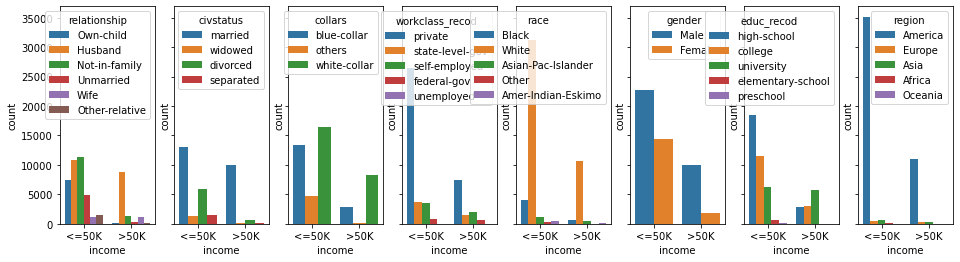

In [5]:
# Analizar las variables discretas
discreeteCols = ['relationship', 'civstatus', 'collars', 'workclass_recod', 'race', 'gender','educ_recod','region']
fig, ax = plt.subplots(1, len(discreeteCols), sharey=True)
for i, col in enumerate(discreeteCols):
    sns.countplot(x='income', ax=ax[i], hue=col, data=df)

En base a lo obtenido, podemos destacar que:
<ul>
<li>Según <code>collars</code> y <code>workclass</code>, la mayoría de las personas que ganan mas de 50k trabajan para privados y en general son aquellos que son <code>white-collar</code> los que generalmente ganan mas de 50k. Notamos también que la brecha entre <code>white-collar</code> y <code>blue-collar</code> es mayor para los que ganan mas de 50k.</li>
<li>Según <code>relationship</code> y <code>civstatus</code> notamos que la mayoría de aquellos que ganan mas de 50k están casados.</li>
<li>Para <code>race</code> y <code>gender</code> no hay una diferencia suficiente entre la proporción de los que ganan mas o menos que 50k aparte de la cantidad.</li>
</ul>

Pasamos a analizar las variables perdidas.

<AxesSubplot:>

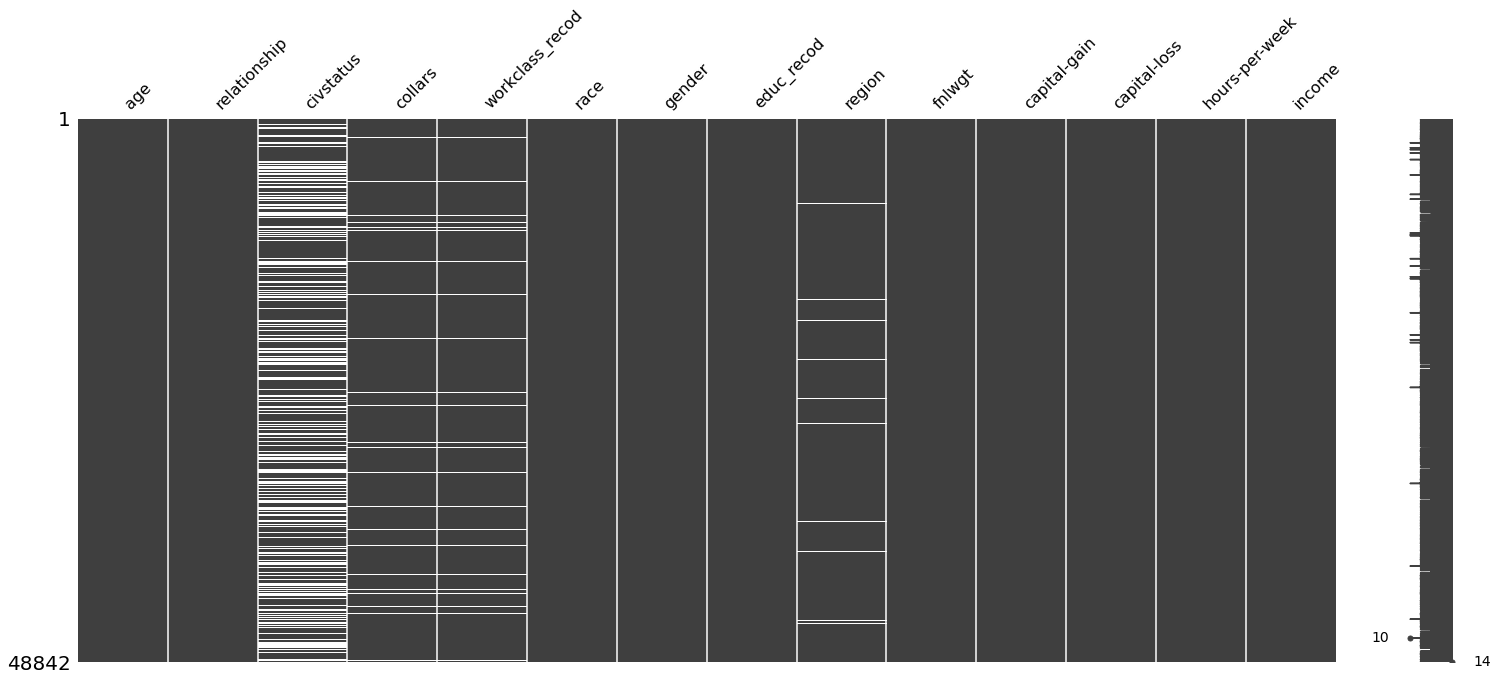

In [6]:
# Copiamos a un DF con sólo las variables recodificadas
parsedDf = df.loc[:, ['age', 'relationship', 'civstatus', 'collars', 'workclass_recod', 'race', 'gender','educ_recod','region', 'fnlwgt','capital-gain', 'capital-loss', 'hours-per-week','income']]
# Se binariza la variable income
parsedDf['income'] = np.where(parsedDf['income'] == '>50K', 1, 0)
# Vemos las variables perdidas
msngo.matrix(parsedDf)

Vemos que la columna civstatus tiene un montón de datos perdidos, por lo que es mejor eliminarla del dataframe que eliminar todas aquellas filas de datos perdidos

<AxesSubplot:>

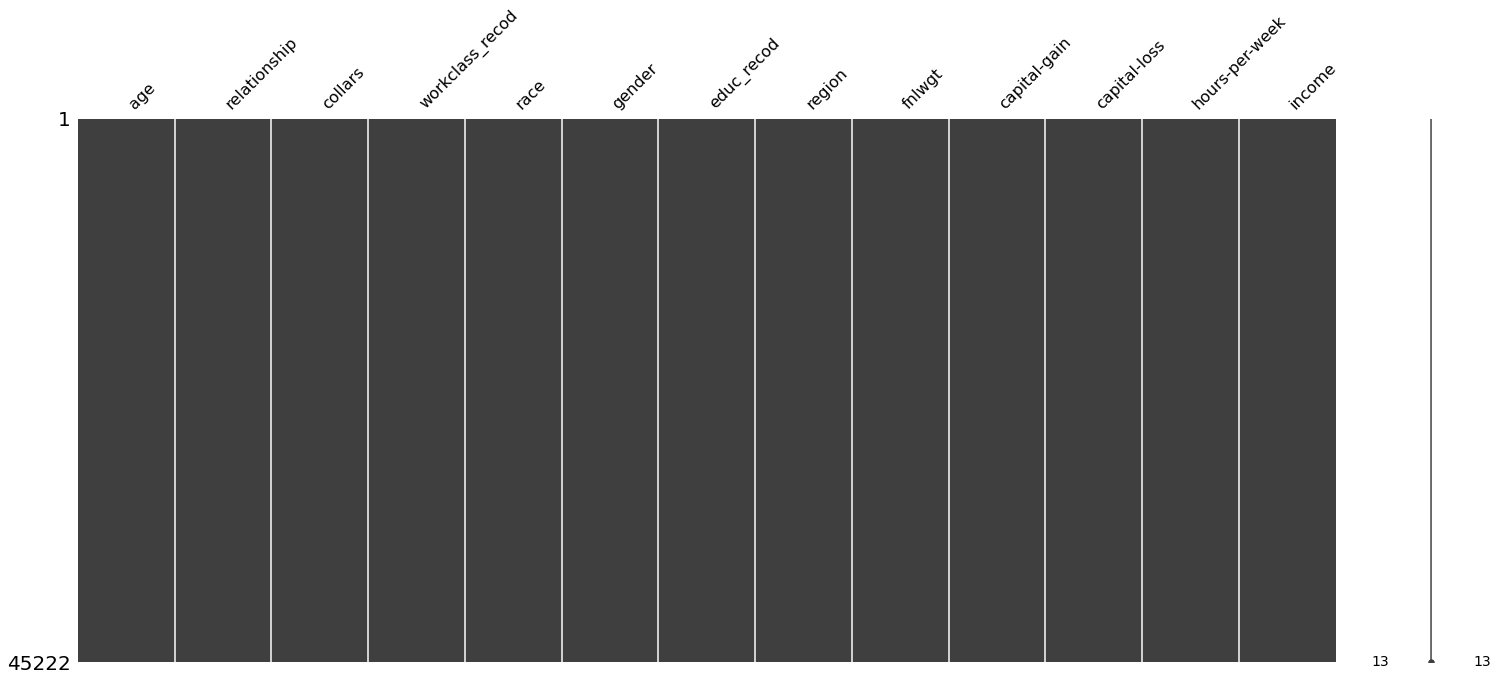

In [7]:
# Eliminamos la columna civstatus
cleanDf = parsedDf.copy().drop(columns=['civstatus']).dropna()
# Hacemos nuevamente el análisis de pérdida
msngo.matrix(cleanDf)

Finalizando, binarizaremos las variables categóricas usando one-hot-encoding

In [42]:
# Usaremos Label encoder para workclass_recod y educ_recod pues son los únicos que podrían ser ordinales y no categóricos.
labelEncoder = LabelEncoder()

auxDf = cleanDf.copy()
for col in ['workclass_recod', 'educ_recod']:
    auxDf[col] = labelEncoder.fit_transform(auxDf[col])
auxDf['']
# Generamos el df con dummies
finalDf = pd.get_dummies(auxDf)
# Renombramos las columnas con _ en vez de - (para statsmodels)
finalDf = finalDf.rename(columns=dict(map(lambda x: [x, x.replace('-', '_')], finalDf.columns)))


## __Hito 3, Modelación descriptiva__

Analizamos la matriz de correlación

<AxesSubplot:>

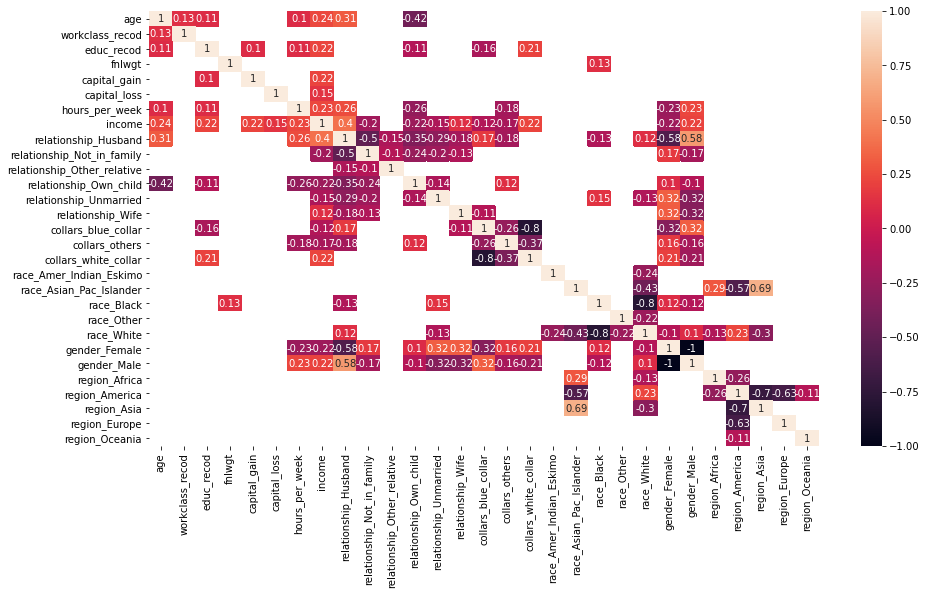

In [60]:
plt.figure(figsize=(15, 8))

corrMatrix = finalDf.loc[:,:].corr()

filteredMatrix = corrMatrix[(corrMatrix > 0.1) | (corrMatrix < -0.1)]

sns.heatmap(filteredMatrix, annot=True)

Podemos observar que para nuestro valor objetivo <code>income</code> no existe una correlación muy fuerte con otra columna. Las principales relaciones directas son <code>relationship_Husband</code> con 0.4 seguida por <code>age, educ_recod, capital_gain y capital_loss</code> con magnitudes cercanas a 0.2. Las relaciones inversas son también bajas en magnitud y son con respecto a columnas binarias principalmente, lo que le da poca significancia al valor conseguido.

Luego haremos la regresión logística y analizaremos los resultados asi como los valores estadísticos principales.

In [151]:
# Conseguido desde https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d y levemente ajustado
class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y, cols):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = pd.Series(p_values, index=cols)
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        return self

In [158]:
# Definimos una función para evaluar el desempeño del modelo obtenido. Retorna 
def getLogisticModelAnalysis(df, cols, y):
    # se generan los subconjuntos de entrenamiento
    x_train, x_test, y_train, y_test = train_test_split(df.loc[:,cols], df[y], test_size=.33)
    # se estandarizan las matrices
    x_train_std = StandardScaler().fit_transform(x_train)
    x_test_std = StandardScaler().fit_transform(x_test)

    # Se implementa el modelo usando nuesto bootstrap de sklearn
    regression = LogisticReg()
    regression.fit(x_train_std, y_train, cols)
    default_model = regression.model

    # se consiguen las predicciones para el conjunto de testeo
    y_test_predict = default_model.predict(x_test_std)
    y_test_predict_proba = default_model.predict_proba(x_test_std)[:, 1]

    # se reportan las Métricas
    print(classification_report(y_test, y_test_predict))

    # se consiguen los datos para la curva ROC
    false_positive, true_positive, threshold = roc_curve(y_test, y_test_predict_proba)

    # Plot ROC curve
    plt.title('Curva ROC')
    plt.plot(false_positive, true_positive, lw=1)
    plt.plot([0, 1], ls="--", lw=1)
    plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] ,
    c='limegreen', lw=3)
    plt.ylabel('Verdaderos Positivos')
    plt.xlabel('Falsos Positivos')
    print("Roc Score: {}".format(roc_auc_score(y_test, y_test_predict_proba)))
    return regression

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11158
           1       0.70      0.57      0.63      3766

    accuracy                           0.83     14924
   macro avg       0.78      0.74      0.76     14924
weighted avg       0.82      0.83      0.82     14924

Roc Score: 0.8855647938931905
age                             3.800137e-44
workclass_recod                 4.771327e-03
educ_recod                      2.892786e-69
fnlwgt                          9.053995e-03
capital_gain                   3.448951e-212
capital_loss                    1.017360e-80
hours_per_week                  6.899496e-85
relationship_Husband                     NaN
relationship_Not_in_family               NaN
relationship_Other_relative              NaN
relationship_Own_child                   NaN
relationship_Unmarried                   NaN
relationship_Wife                        NaN
collars_blue_collar             9.999998e-01
collars_other

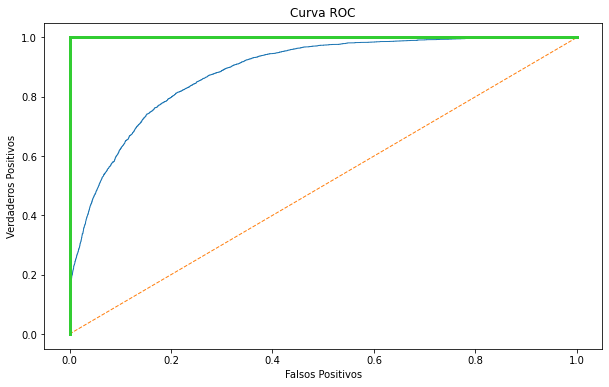

In [200]:
# Generamos el modelo usando todos los atributos sin income.
attributes = list(filter(lambda x: x != 'income', finalDf.columns))
model = getLogisticModelAnalysis(finalDf, attributes, 'income')
# Mostramos lo pvalores
print(model.p_values)


Vemos que hay muchas columnas con p valor cercano a 1, lo que habla muy mal de lo que aportan aquellas columnas al modelo. Podemos observar también que el modelo termina con un buen puntaje ROC de ~0.88 .


              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11206
           1       0.71      0.31      0.43      3718

    accuracy                           0.80     14924
   macro avg       0.76      0.63      0.65     14924
weighted avg       0.78      0.80      0.77     14924

Roc Score: 0.7931463726350395
age                8.569970e-239
workclass_recod     6.397284e-01
educ_recod         1.252793e-167
fnlwgt              6.911677e-04
capital_gain       1.224731e-275
capital_loss       5.945766e-105
hours_per_week     1.089274e-222
dtype: float64


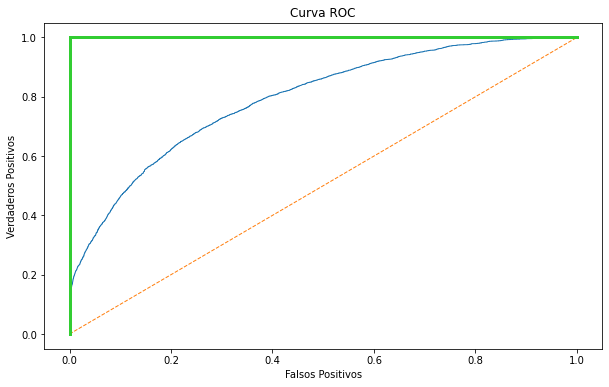

In [202]:

# Dejamos sólo las columnas con p-value < 0.05
depuratedCols = list(filter(lambda x: model.p_values[x] < 0.1 or model.p_values[x] == 'NaN' , attributes))
# Creamos el modelo con las nuevas columnas
depuratedModel = getLogisticModelAnalysis(finalDf, depuratedCols, 'income')
print(depuratedModel.p_values)

Vemos que el modelos tiene muchos atributos 

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     11241
           1       0.70      0.31      0.43      3683

    accuracy                           0.80     14924
   macro avg       0.75      0.63      0.65     14924
weighted avg       0.78      0.80      0.77     14924

Roc Score: 0.7890857894026325
age               3.031886e-231
educ_recod        2.336926e-176
fnlwgt             1.207610e-02
capital_gain      3.449234e-292
capital_loss      4.515780e-112
hours_per_week    2.282773e-222
dtype: float64


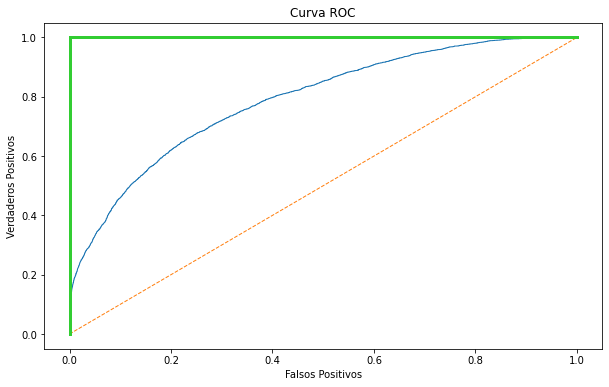

In [156]:
# Dejamos sólo las columnas con p-value < 0.05
reDepuratedCols = list(filter(lambda x: depuratedModel.p_values[x] < 0.05 , depuratedCols))
# Creamos el modelo con las nuevas columnas
reDepuratedModel = getLogisticModelAnalysis(finalDf, reDepuratedCols, 'income')
print(reDepuratedModel.p_values)